In [1]:
# For Preprocessing part
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# For Modelling part
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

# For Evaluation and Tuning part
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.model_selection import cross_val_score
import optuna


In [41]:
data = pd.read_csv('car_last.csv')
df = data.copy()
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.9000,0,42.3100,2.5720,211.0964,8.1060
1,1,12-02-2010,1641957.4400,1,38.5100,2.5480,211.2422,8.1060
2,1,19-02-2010,1611968.1700,0,39.9300,2.5140,211.2891,8.1060
3,1,26-02-2010,1409727.5900,0,46.6300,2.5610,211.3196,8.1060
4,1,05-03-2010,1554806.6800,0,46.5000,2.6250,211.3501,8.1060
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.9500,0,64.8800,3.9970,192.0136,8.6840
6431,45,05-10-2012,733455.0700,0,64.8900,3.9850,192.1704,8.6670
6432,45,12-10-2012,734464.3600,0,54.4700,4.0000,192.3273,8.6670
6433,45,19-10-2012,718125.5300,0,56.4700,3.9690,192.3309,8.6670


In [3]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [4]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

In [6]:
data.drop(columns = ['Date'], inplace = True)

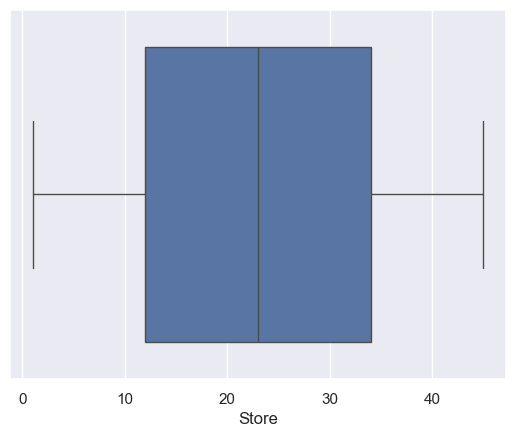

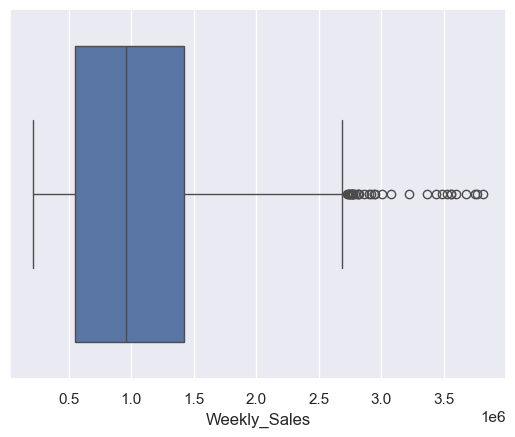

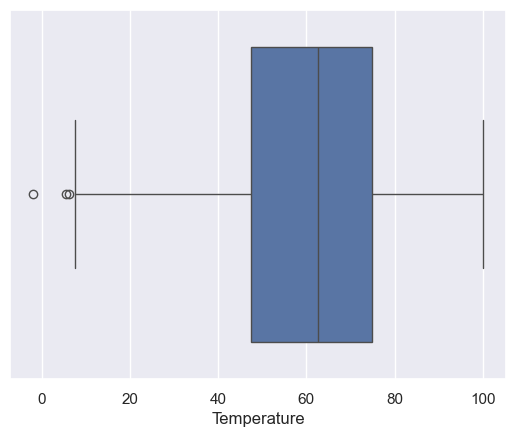

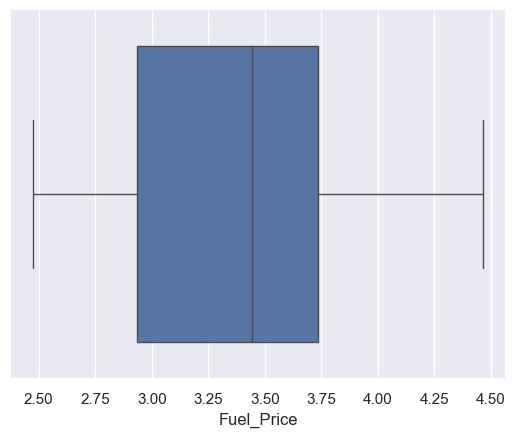

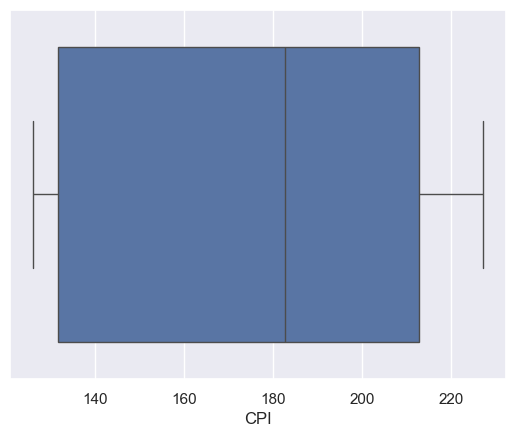

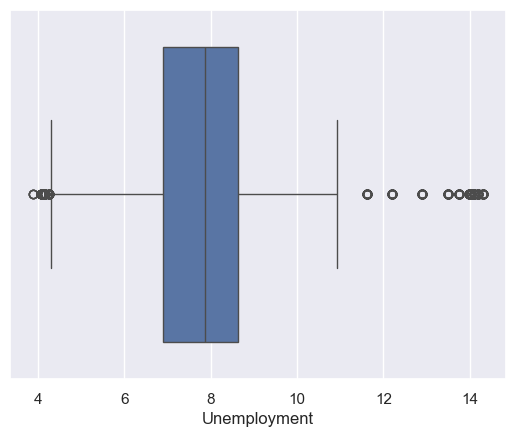

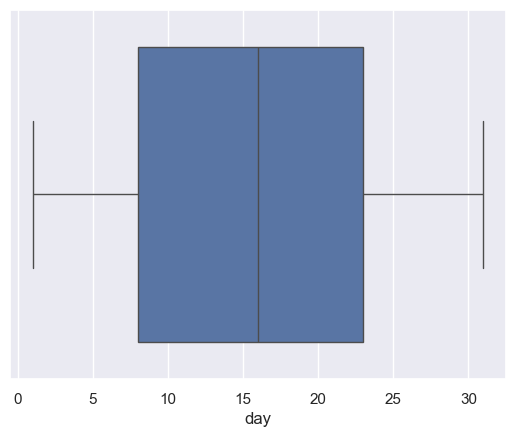

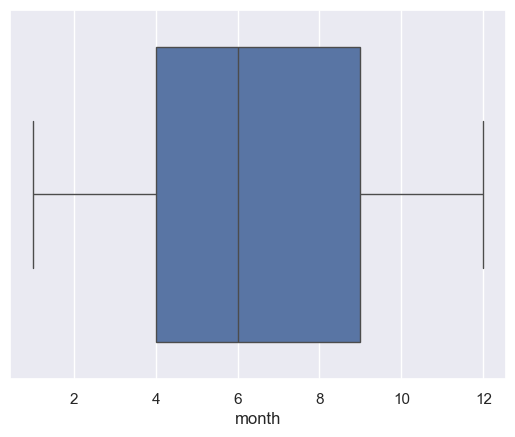

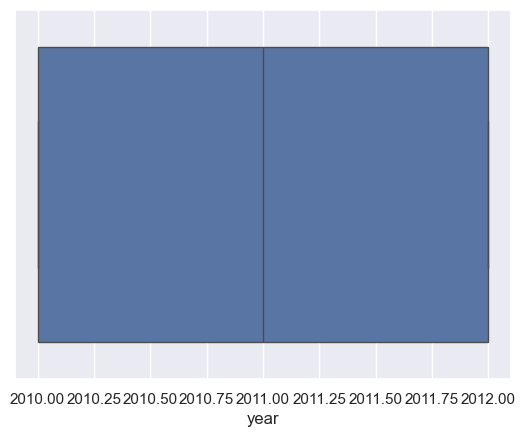

In [7]:
# checking outliers
for column in data.columns:
    if data[column].dtypes != object and column != 'Holiday_Flag':
        sns.boxplot(data = data, x = column)
        plt.show()

In [8]:
q1 = data.quantile(0.25, numeric_only = True)
q3 = data.quantile(0.75, numeric_only = True)

IQR = q3 - q1
Upper = q3 + 1.5 * IQR
Lower = q1 - 1.5 * IQR

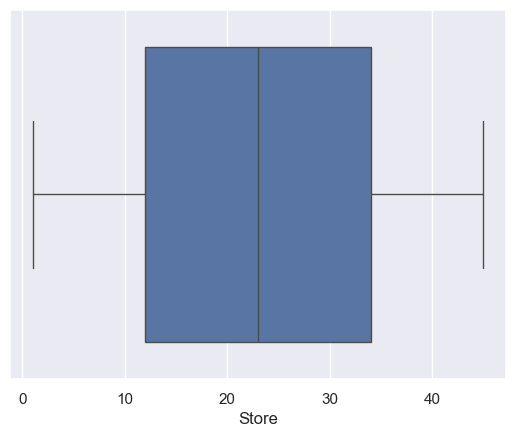

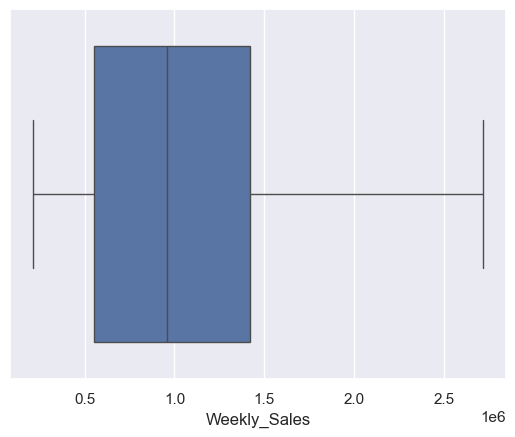

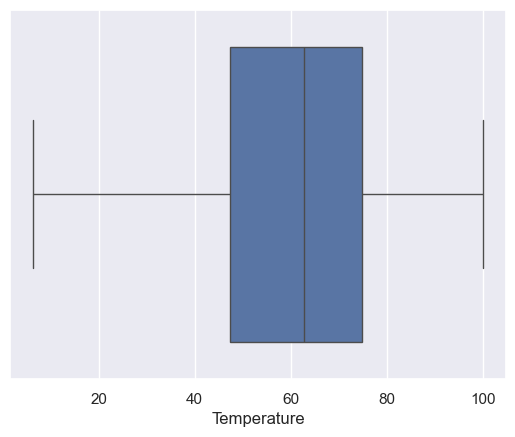

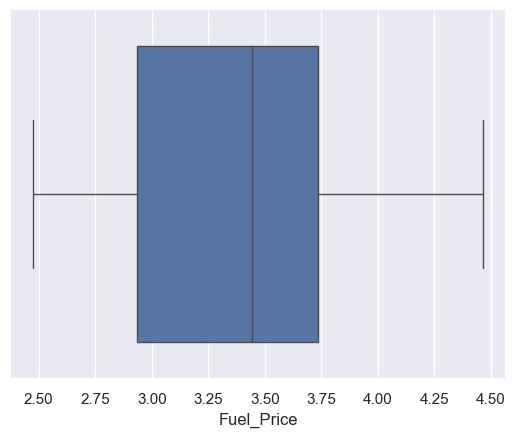

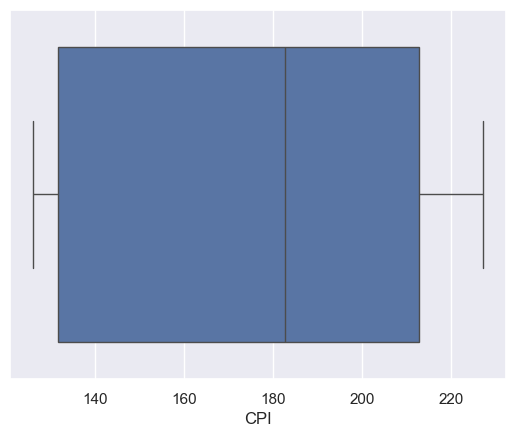

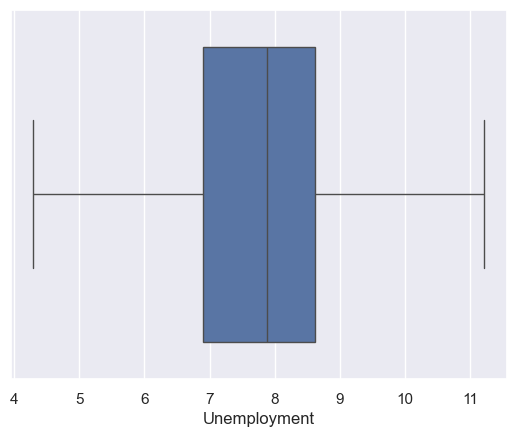

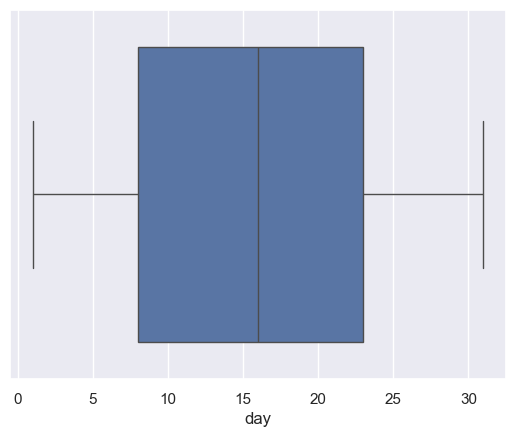

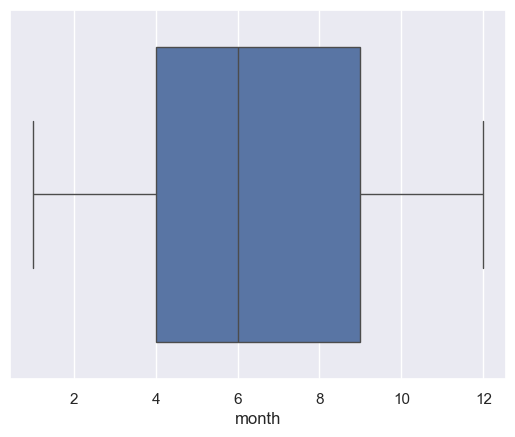

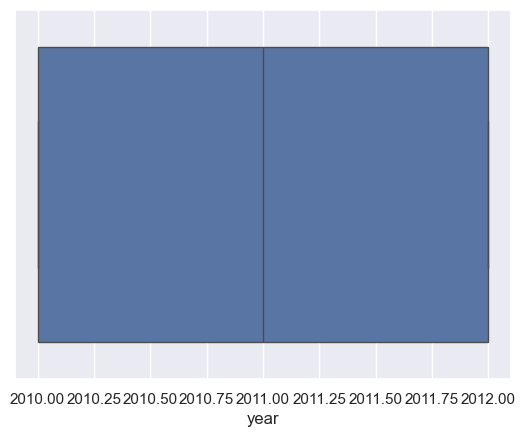

In [9]:
# All outliers has been replace with Upper and Lower boundries

for column in data.columns:
    if data[column].dtypes != object and column != 'Holiday_Flag':
        data[column] = np.where(data[column] > Upper[column], Upper[column], data[column])
        data[column] = np.where(data[column] < Lower[column], Lower[column], data[column])
        sns.boxplot(data = data, x = column)
        plt.show()

In [10]:
# since data is not distributed normally, method will be spearman. And if independent columns' correlation with target is more than 40% is selected  
def target_correlation(data, target, threshold=0.05):
    corr_matrix = data.corr(method='spearman', numeric_only = True)
    
    target_correlations = corr_matrix[target].abs() > threshold
    
    variables_explaining_target = target_correlations[target_correlations].index.tolist()

    variables_explaining_target.remove(target)
    
    result_explaining_target = pd.DataFrame(
    {'Variable': variables_explaining_target,
    'Correlation with Target': corr_matrix.loc[variables_explaining_target, target]})
    
    result_explaining_target.reset_index(drop=True, inplace=True)
    
    return result_explaining_target


target_result = target_correlation(data, 'Weekly_Sales')

target_result

,Variable,Correlation with Target
0,Store,-0.309225
1,Temperature,-0.070963
2,CPI,-0.055039
3,Unemployment,-0.062145
4,month,0.051102


In [11]:
# if intercorrelation between independent columns are more than 80% will be dropped
def intercorrelation(data, target, threshold=0.6):
    corr_matrix = data.drop(columns=[target]).corr(method='spearman', numeric_only = True)
    
    highly_correlated_variables = (np.abs(corr_matrix) > threshold) & (corr_matrix != 1.0)
    
    independent_variable_pairs = np.where(highly_correlated_variables)
    
    correlated_pairs_set = set()
   
    for var1, var2 in zip(independent_variable_pairs[0], independent_variable_pairs[1]):

        if var1 < var2:
            correlated_pairs_set.add((corr_matrix.index[var1], corr_matrix.columns[var2]))
        else:
            correlated_pairs_set.add((corr_matrix.index[var2], corr_matrix.columns[var1]))
    
    result_intercorrelated_independent = pd.DataFrame(list(correlated_pairs_set), columns=['Variable 1', 'Variable 2'])
    
    return result_intercorrelated_independent

intercorrelated_result = intercorrelation(data, 'Weekly_Sales')
intercorrelated_result

,Variable 1,Variable 2
0,Fuel_Price,year


In [12]:
target_result.Variable.tolist()

['Store', 'Temperature', 'CPI', 'Unemployment', 'month']

In [13]:
def calculate_vif(data, variables):
    vif_data = data[variables]
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    vif_result = pd.DataFrame({'VIF': vif_values, 'Features': variables})
    return vif_result

vif_result = calculate_vif(data, [ 
                                    'Store', 
                                    #'Temperature', 
                                    'CPI', 
                                    #'Unemployment', 
                                    'month'
])

vif_result

,VIF,Features
0,3.289880,Store
1,5.397169,CPI
2,4.353666,month


In [14]:
input = data[['Store', 'CPI', 'month']]
output = data['Weekly_Sales']

In [15]:
# we can use scale method for scaling all columns
scaler = StandardScaler()
scaler.fit(input)

inputs_scaled = scaler.transform(input)

data_scaled = pd.DataFrame(inputs_scaled, columns=input.columns)

data_scaled

,Store,CPI,month
0,-1.693979,1.004175,-1.373525
1,-1.693979,1.007880,-1.373525
2,-1.693979,1.009074,-1.373525
3,-1.693979,1.009849,-1.373525
4,-1.693979,1.010624,-1.064698
...,...,...,...
6430,1.693979,0.519270,0.788265
6431,1.693979,0.523256,1.097092
6432,1.693979,0.527241,1.097092
6433,1.693979,0.527332,1.097092


In [16]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(data_scaled, output, test_size = 0.2, random_state = 42)

In [42]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df.drop(columns = ['Date'], inplace = True)

In [43]:
input = df.drop(columns = ['Weekly_Sales'])
output = df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size = 0.2, random_state = 42)

In [19]:
pd.options.display.float_format = "{:.4f}".format
# function for training and evaluation of the model
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # calculating metrics for test data
        mae_test  = mean_absolute_error(y_test,y_pred_test)
        mse_test = mean_squared_error(y_test,y_pred_test)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_test,y_pred_test)

        # calculating metrics for train data
        mae_train  = mean_absolute_error(y_train,y_pred_train)
        mse_train = mean_squared_error(y_train,y_pred_train)
        rmse_train = np.sqrt(mse_train)
        r2_train = r2_score(y_train,y_pred_train)
    
        # Create a DataFrame to store the results
        results_dict = {
                    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
                    'Train': [mae_train, mse_train, rmse_train, r2_train],
                    'Test': [mae_test, mse_test, rmse_test, r2_test]
        }
        results_df = pd.DataFrame(results_dict)
    
        print(f'Model Performance for {model_name}')
        print(results_df)
        print()
    
        return 100*r2_train, 100*r2_test

In [20]:
# taken 'models' list and models added to it
models = []

# all models created
lin_regr_model = LinearRegression()
xgb_model_def = XGBRegressor()
lgb_model_def = LGBMRegressor()
catboost_model_def = CatBoostRegressor()
random_forest_def = RandomForestRegressor()


models.extend([
    ('Linear Regression', lin_regr_model),
    ('XGBoost', xgb_model_def),
    ('LightGBM', lgb_model_def),
    ('CatBoost', catboost_model_def),
    ('Random Forest', random_forest_def)
])

In [21]:
r2_df = pd.DataFrame(columns=['Model', 'R2_train', 'R2_test'])

for model_name, model in models:
    if model_name == 'Linear Regression':
        r2_train, r2_test = train_and_evaluate_model(model_name, model, X_train_lin, y_train_lin, X_test_lin, y_test_lin)
    else:
        r2_train, r2_test = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
    if r2_train is not None:
        r2_df = pd.concat([r2_df, pd.DataFrame({'Model': [model_name], 'R2_train': [r2_train], 'R2_test': [r2_test]})], ignore_index=True)
        
r2_df_sorted = r2_df.sort_values(by='R2_test', ascending=False)

Model Performance for Linear Regression
  Metric             Train              Test
0    MAE       429460.2292       431961.9218
1    MSE 267478543306.5671 265638117342.4967
2   RMSE       517183.2783       515400.9287
3     R2            0.1373            0.1496



C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\447861561.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_df = pd.concat([r2_df, pd.DataFrame({'Model': [model_name], 'R2_train': [r2_train], 'R2_test': [r2_test]})], ignore_index=True)


Model Performance for XGBoost
  Metric          Train            Test
0    MAE     21183.2090      49311.6036
1    MSE 922017830.4047 7401783053.9822
2   RMSE     30364.7465      86033.6158
3     R2         0.9971          0.9770

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 9
[LightGBM] [Info] Start training from score 1044996.414472
Model Performance for LightGBM
  Metric           Train            Test
0    MAE      41203.5470      52756.9140
1    MSE 3888064927.3182 7598526743.3714
2   RMSE      62354.3497      87169.5288
3     R2          0.9878          0.9764

Learning rate set to 0.053042
0:	learn: 549942.3740904	total: 185ms	remaining: 3m 4s
1:	learn: 537645.4758019	total: 192ms

In [22]:
r2_df_sorted

,Model,R2_train,R2_test
3,CatBoost,99.1255,97.8644
1,XGBoost,99.7096,97.7024
2,LightGBM,98.7755,97.6413
4,Random Forest,99.4354,95.9367
0,Linear Regression,13.7316,14.9594


In [23]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5,1), #  fraction of the training data used to train each tree.
         # Using a fraction of the data can help to prevent overfitting and improve generalization.
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5,1),
        'gamma': trial.suggest_int('gamma', 0,5)
        # Increasing the gamma value can help to prevent overfitting
        # Should be used only when you are using high depth
}
    xgb_reg = XGBRegressor(**param)

    auc = cross_val_score(xgb_reg, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model = XGBRegressor(**best_params)

[I 2024-06-14 17:02:10,398] A new study created in memory with name: no-name-aa2349a1-5132-4b93-ba58-feb564519d64
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3531340600.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3531340600.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,1), #  fraction of the training data used to train each tree.
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3531340600.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

Best trial:
  Value: 0.972
  Params:  {'n_estimators': 163, 'learning_rate': 0.1870455268580211, 'max_depth': 8, 'subsample': 0.7331672578135676, 'colsample_bytree': 0.8194997354710646, 'gamma': 5}


In [24]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100)
    }

    lgb_reg = LGBMRegressor(**param)

    auc = cross_val_score(lgb_reg, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_lgb_model = LGBMRegressor(**best_params)

[I 2024-06-14 17:02:34,749] A new study created in memory with name: no-name-66770ee3-9cd0-4333-bc6e-a2936933db1f
C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\1177000557.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
[I 2024-06-14 17:02:37,830] Trial 0 finished with value: 0.9748593091717602 and parameters: {'n_estimators': 701, 'learning_rate': 0.05429404041917919, 'max_depth': 5, 'num_leaves': 92}. Best is trial 0 with value: 0.9748593091717602.
[I 2024-06-14 17:02:41,722] Trial 1 finished with value: 0.9708175824380195 and parameters: {'n_estimators': 296, 'learning_rate': 0.02636262640497804, 'max_depth': 10, 'num_leaves': 92}. Best is trial 0 with value: 0.9748593091717602.
[I 2024-06-14 17:02:45,461] Trial 2 finished with value: 0.975224260895

Best trial:
  Value: 0.975
  Params:  {'n_estimators': 843, 'learning_rate': 0.033666676199158134, 'max_depth': 6, 'num_leaves': 65}


In [25]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

    rf_reg = RandomForestRegressor(**param)

    auc = cross_val_score(rf_reg, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value)) 
print('  Params: ', best_params)

best_rf_model = RandomForestRegressor(**best_params)

[I 2024-06-14 17:03:05,559] A new study created in memory with name: no-name-6937ff34-5f38-4cd7-b140-b7dda712fc4f
[I 2024-06-14 17:03:18,087] Trial 0 finished with value: 0.6496839554343464 and parameters: {'n_estimators': 912, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6496839554343464.
[I 2024-06-14 17:03:26,101] Trial 1 finished with value: 0.7034056068138138 and parameters: {'n_estimators': 533, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7034056068138138.
[I 2024-06-14 17:03:37,779] Trial 2 finished with value: 0.7074277344658347 and parameters: {'n_estimators': 794, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 2 with value: 0.7074277344658347.
[I 2024-06-14 17:03:45,111] Trial 3 finished with value: 0.7240231613185396 and parameters: {'n_estimators': 508, 'max_depth': 8, 'mi

Best trial:
  Value: 0.724
  Params:  {'n_estimators': 508, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'log2'}


In [26]:
# optimized models created and added to the list
models_optimized = []

models_optimized.extend([
    ('XGBoost Optuna', best_xgb_model),
    ('LightGBM Optuna', best_lgb_model),
    ('RandomForest Optuna', best_rf_model)
])

In [27]:
r2_df_optuna = pd.DataFrame(columns=['Model', 'R2_train', 'R2_test'])

for model_name, model in models_optimized:    
    r2_train, r2_test = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
    if r2_train is not None:
        r2_df_optuna = pd.concat([r2_df_optuna, pd.DataFrame({'Model': [model_name], 'R2_train': [r2_train], 'R2_test': [r2_test]})], ignore_index=True)
        
r2_df_sorted_optuna = r2_df_optuna.sort_values(by='R2_test', ascending=False)

Model Performance for XGBoost Optuna
  Metric          Train            Test
0    MAE      8604.7566      48119.0850
1    MSE 136800074.6634 7432871050.4685
2   RMSE     11696.1564      86214.1001
3     R2         0.9996          0.9769

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 9
[LightGBM] [Info] Start training from score 1044996.414472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

C:\Users\Admin\AppData\Local\Temp\ipykernel_7508\3430240768.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_df_optuna = pd.concat([r2_df_optuna, pd.DataFrame({'Model': [model_name], 'R2_train': [r2_train], 'R2_test': [r2_test]})], ignore_index=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [28]:
final_review = pd.concat([r2_df_sorted,r2_df_sorted_optuna], axis=0)

final_review_sorted = final_review.sort_values(by='R2_test', ascending=False)
final_review_sorted.reset_index(drop=True, inplace=True)

final_review_sorted

,Model,R2_train,R2_test
0,LightGBM Optuna,99.2223,97.8799
1,CatBoost,99.1255,97.8644
2,XGBoost,99.7096,97.7024
3,XGBoost Optuna,99.9569,97.6928
4,LightGBM,98.7755,97.6413
5,Random Forest,99.4354,95.9367
6,RandomForest Optuna,76.2632,74.0953
7,Linear Regression,13.7316,14.9594


In [29]:
from feature_engine.selection import SelectBySingleFeaturePerformance

selector = SelectBySingleFeaturePerformance(
    estimator=best_lgb_model,
    scoring='r2'
)

# Fit the selector to the data
selector.fit(X_train, y_train)

X_selected = selector.transform(X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 1
[LightGBM] [Info] Start training from score 1037946.636414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [30]:
X_selected.columns

Index(['Store', 'Unemployment'], dtype='object')

In [31]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(best_lgb_model,
          k_features=5,  # number of features to select
          forward=True,  # forward selection
          floating=False,  # if True, performs SFFS
          scoring='r2',
          cv=5,
          n_jobs=-1)

# Fit the selector to the training data
sfs.fit(X_train, y_train)

# Get the selected feature names
selected_features = list(sfs.k_feature_names_)
print("Selected features:", selected_features)

Selected features: ['Store', 'Holiday_Flag', 'CPI', 'day', 'month']


In [44]:
X_train = X_train[['Store', 'Holiday_Flag', 'CPI', 'day', 'month', 'year']]
X_test = X_test[['Store', 'Holiday_Flag', 'CPI', 'day', 'month', 'year']]

train_and_evaluate_model('LGBM Optuna', best_lgb_model, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 6
[LightGBM] [Info] Start training from score 1044996.414472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

(99.02190296327024, 97.84506661140485)

In [45]:
best_lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 6
[LightGBM] [Info] Start training from score 1044996.414472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMRegressor(learning_rate=0.033666676199158134, max_depth=6, n_estimators=843,
              num_leaves=65)

In [46]:
best_lgb_model.booster_.save_model('best_model.txt')

In [47]:
data.Holiday_Flag.unique()

array([0, 1], dtype=int64)

In [48]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.9000,0,42.3100,2.5720,211.0964,8.1060
1,1,12-02-2010,1641957.4400,1,38.5100,2.5480,211.2422,8.1060
2,1,19-02-2010,1611968.1700,0,39.9300,2.5140,211.2891,8.1060
3,1,26-02-2010,1409727.5900,0,46.6300,2.5610,211.3196,8.1060
4,1,05-03-2010,1554806.6800,0,46.5000,2.6250,211.3501,8.1060
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.9500,0,64.8800,3.9970,192.0136,8.6840
6431,45,05-10-2012,733455.0700,0,64.8900,3.9850,192.1704,8.6670
6432,45,12-10-2012,734464.3600,0,54.4700,4.0000,192.3273,8.6670
6433,45,19-10-2012,718125.5300,0,56.4700,3.9690,192.3309,8.6670
